In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

#You can import other libraries if you want

2023-12-13 16:33:37.593014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-12-13 16:33:39.648876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-13 16:33:41.516341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 7918 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB MIG 1g.10gb, pci bus id: 0000:85:00.0, compute capability: 8.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9822385336086021801
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 8302624768
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 3141751206769318988
 physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-80GB MIG 1g.10gb, pci bus id: 0000:85:00.0, compute capability: 8.0"
 xla_global_id: 416903419]

In [3]:
###### DO NOT MODIFY THIS PART
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed) # fix your random seed : In same model, you produce the same result
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1) 
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
######

2023-12-13 16:33:41.566045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7918 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB MIG 1g.10gb, pci bus id: 0000:85:00.0, compute capability: 8.0


In [4]:
artists = pd.read_csv('./train/artists.csv') # your own directory
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe
artists_top = artists[artists['paintings'] >= 0].reset_index()
artists_top = artists_top[['name', 'paintings']]

updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [5]:
# Explore images of top artists
images_dir = './train/images' #Type Your Own Data Directory
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:    
    if os.path.exists(os.path.join(images_dir, name)):  # images_idr: directory folder // name: label (y) 
        print("find -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

find --> ./train/images/Vincent_van_Gogh
find --> ./train/images/Edgar_Degas
find --> ./train/images/Pablo_Picasso
find --> ./train/images/Pierre-Auguste_Renoir
find --> ./train/images/Albrecht_Dürer
find --> ./train/images/Paul_Gauguin
find --> ./train/images/Francisco_Goya
find --> ./train/images/Rembrandt
find --> ./train/images/Alfred_Sisley
find --> ./train/images/Titian
find --> ./train/images/Marc_Chagall


In [7]:
batch_size = 32#Type your own batch size
input_shape = (128,128) #Type your own input shape
n_classes = artists_top.shape[0]

#Image data generate with validation data fraction of 0.2 and data rescale 1/255.
train_datagen = ImageDataGenerator(validation_split=0.2,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3092 images belonging to 11 classes.
Found 767 images belonging to 11 classes.
Total number of batches = 96 and 23


In [8]:
#######################
# Make your own model #
#######################
from tensorflow.keras.layers import Input



def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

def ResNet_Custom(input_shape = (input_shape[0], input_shape[1], 3), classes = 11):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 64, (3,3)) #conv
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(classes, activation = 'softmax')(X)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNetCL")
    
    return model



In [10]:
model = ResNet_Custom()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau


lr_cb = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=4, verbose=1)

In [12]:
#training


n_epoch = 100#Your Own Epoch num

history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,callbacks=[lr_cb]) #you can add kwargs if you want

/tmp/ipykernel_38235/2444437646.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/100


2023-12-13 16:34:17.075269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-12-13 16:34:18.933023: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-13 16:34:21.754124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-13 16:34:21.771902: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x555570b8c8f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-13 16:34:21.771949: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB MIG 1g.10gb, Compute Capability 8.0
2023-12-13 16:34:21.777424: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-13 16:3

96/96 [==============================] - 95s 718ms/step - loss: 2.0078 - accuracy: 0.3605 - val_loss: 83.7653 - val_accuracy: 0.0856 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 61s 636ms/step - loss: 1.6530 - accuracy: 0.4245 - val_loss: 12.3519 - val_accuracy: 0.1087 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 62s 643ms/step - loss: 1.5414 - accuracy: 0.4670 - val_loss: 2.2125 - val_accuracy: 0.3682 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 61s 631ms/step - loss: 1.4668 - accuracy: 0.5072 - val_loss: 5.1496 - val_accuracy: 0.1712 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 61s 638ms/step - loss: 1.4011 - accuracy: 0.5157 - val_loss: 3.6748 - val_accuracy: 0.3207 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 62s 642ms/step - loss: 1.3539 - accuracy: 0.5389 - val_loss: 2.0533 - val_accuracy: 0.4918 - lr: 0.0010
Epoch 7/100
96/96 [==============================] - 60s 625ms/step 

96/96 [==============================] - 62s 645ms/step - loss: 0.2567 - accuracy: 0.9199 - val_loss: 0.7704 - val_accuracy: 0.7568 - lr: 1.0000e-07
Epoch 49/100
96/96 [==============================] - 63s 649ms/step - loss: 0.2342 - accuracy: 0.9275 - val_loss: 0.7682 - val_accuracy: 0.7541 - lr: 1.0000e-07
Epoch 50/100
96/96 [==============================] - ETA: 0s - loss: 0.2402 - accuracy: 0.9252
Epoch 50: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
96/96 [==============================] - 61s 634ms/step - loss: 0.2402 - accuracy: 0.9252 - val_loss: 0.7699 - val_accuracy: 0.7568 - lr: 1.0000e-07
Epoch 51/100
96/96 [==============================] - 62s 646ms/step - loss: 0.2369 - accuracy: 0.9275 - val_loss: 0.7428 - val_accuracy: 0.7636 - lr: 1.0000e-08
Epoch 52/100
96/96 [==============================] - 61s 635ms/step - loss: 0.2476 - accuracy: 0.9209 - val_loss: 0.7559 - val_accuracy: 0.7568 - lr: 1.0000e-08
Epoch 53/100
96/96 [=======================

Epoch 89/100
96/96 [==============================] - 63s 650ms/step - loss: 0.2461 - accuracy: 0.9275 - val_loss: 0.7666 - val_accuracy: 0.7568 - lr: 1.0000e-17
Epoch 90/100
96/96 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.9193
Epoch 90: ReduceLROnPlateau reducing learning rate to 1.0000000664932204e-18.
96/96 [==============================] - 63s 654ms/step - loss: 0.2582 - accuracy: 0.9193 - val_loss: 0.7628 - val_accuracy: 0.7582 - lr: 1.0000e-17
Epoch 91/100
96/96 [==============================] - 64s 665ms/step - loss: 0.2430 - accuracy: 0.9219 - val_loss: 0.7287 - val_accuracy: 0.7677 - lr: 1.0000e-18
Epoch 92/100
96/96 [==============================] - 66s 682ms/step - loss: 0.2433 - accuracy: 0.9294 - val_loss: 0.7596 - val_accuracy: 0.7582 - lr: 1.0000e-18
Epoch 93/100
96/96 [==============================] - 63s 656ms/step - loss: 0.2545 - accuracy: 0.9193 - val_loss: 0.7690 - val_accuracy: 0.7554 - lr: 1.0000e-18
Epoch 94/100
96/96 [=========

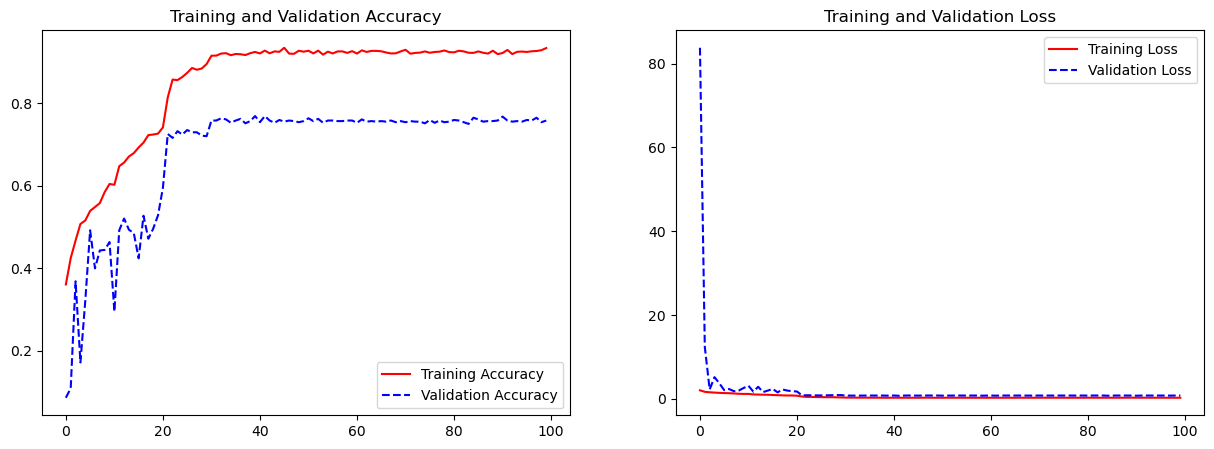

In [13]:
his = {}
his['loss'] = history.history['loss']
his['accuracy'] = history.history['accuracy'] 
his['val_loss'] = history.history['val_loss']
his['val_accuracy'] = history.history['val_accuracy']

# Plot the training graph
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(his)

In [14]:
model.save("resnet_128x128.h5")